# Normalization errors for Δ47 measurements

This notebook is not designed to process real data, but to illustrate how Δ47 normalization errors behave, and to allow users to play around with different situations.

First we define a function which will process some data (anchors and unknowns), compute all errors, and generate plots.


In [10]:
import numpy as np
from numpy.linalg import inv
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse

def compute_errors(rD47, anchors, unknowns):
    # rD47 is the session-wide D47 reproducibility.
    
    # Arbitrarily define true values for normalization parameters (a,b,c).
    # These values actually don't matter here, but they show up in the calculations.
    a,b,c = 0.9, 1e-4, -0.85
    
    # reorganize the data (bookkeeping, boring)
    data = [{
        'name':x['name'],
        'd47':x['d47'],
        'D47':x['D47'],
        'D47raw':a*x['D47'] + b*x['d47'] + c,
        } for x in anchors for k in range(x['N'])]

    # solve least-squares regression
    A = np.array([[x['D47'], x['d47'], 1.] for x in data])
    Y = np.array([[x['D47raw']] for x in data])
    M = inv( A.T @ A ) @ A.T
    a_fit, b_fit , c_fit = ( M @ Y ).T[0,:]
    CM = inv( A.T @ A )*rD47**2

    # check that we get accurate values of a, b, c
    print()
    print(f'a_fit = {a_fit:.3f}      (true value is {a:.3f}).')
    print(f'b_fit = {b_fit:.2e}   (true value is {b:.2e}).')
    print(f'c_fit = {c_fit:.3f}     (true value is {c:.3f}).')
    
    # Plot results in (d47,D47) space
    d47, D47 = np.meshgrid(np.linspace(-45,+25),np.linspace(0.2,0.8))

    fig = plt.figure(figsize = (15,6.7))
    plt.subplots_adjust(.2,.2,.95,.95,.25,.25)

    ax = plt.subplot(121)
    cs = plt.contour(d47, D47, norm_error(a, CM, d47, D47), colors='r')
    plt.clabel(cs)

    for x in anchors:
        plt.text(x['d47'], x['D47'], f"{x['name']}\n(N = {x['N']})",
            va = 'center', ha = 'center', weight = 'bold')

    for x in unknowns:
        plt.text(x['d47'], x['D47'], f"{x['name']}\n(N = {x['N']})",
            va = 'center', ha = 'center', weight = 'bold', color = 'b')

    plt.xlabel('δ47')
    plt.ylabel('Δ47')
    plt.title('Standard normalization error (nSE)')

    # Plot comparison between both sources of errors
    ax = plt.subplot(122)

    print()
    print()
    print('             Unknown    N    iSE    nSE    tSE')
    print('--------------------  ---  -----  -----  -----')


    xmax = -1
    for x in unknowns:
        inherent_error = rD47 / np.sqrt(x['N']) * 1000
        normalization_error = norm_error(a, CM, x['d47'], x['D47']) * 1000
        plt.plot(inherent_error, normalization_error, 'b+', mew = 2, ms = 8)
        plt.text(inherent_error, normalization_error, f"{x['name']}\n\n",
            va = 'center', ha = 'center', color = 'b', weight = 'bold')

        print(f"{x['name']:>20}  {x['N']:>3}  {inherent_error/1000:.3f}  {normalization_error/1000:.3f}  {np.sqrt(inherent_error**2 + normalization_error**2)/1000:.3f}")

        xmax = max(xmax, inherent_error)
        xmax = max(xmax, normalization_error)

    print('--------------------  ---  -----  -----  -----')
    print()


    N = int(np.floor(np.sqrt(2)*(xmax + 3)**2))
    for e in np.linspace(1, N, N):
        plt.gca().add_artist(
            Ellipse(
                xy = (0,0), width = 2*e, height = 2*e,
                lw = 1, fc = 'none', ec = [.75]*3, ls = '-', zorder = -100 )
                )

    plt.axis([0, xmax + 3, 0, xmax + 3])
    plt.xlabel('iSE (inherent source of error, ppm)')
    plt.ylabel('nSE (normalization error, ppm)')
    plt.show()

def norm_error(a, CM, d47, D47):
    return np.sqrt(
        CM[0,0]*D47**2
        + CM[1,1]*d47**2
        + CM[2,2]
        + 2*CM[0,1]*D47*d47
        + 2*CM[0,2]*D47
        + 2*CM[1,2]*d47
        )/a

To use the above function, we can define the number of anchor measurements and the composition of each anchor, as well as some unknown measurements. For each unknown we can compare “inherent” and “normalization“ standard errors (noted `iSE`, `nSE`) and compute their total standard errors (`tSE`).


a_fit = 0.900      (true value is 0.900).
b_fit = 1.00e-04   (true value is 1.00e-04).
c_fit = -0.850     (true value is -0.850).


             Unknown    N    iSE    nSE    tSE
--------------------  ---  -----  -----  -----
               ETH-4    2  0.011  0.007  0.013
             IAEA-C1    8  0.005  0.004  0.007
             IAEA-C2    8  0.005  0.007  0.009
               MERCK    8  0.005  0.015  0.016
--------------------  ---  -----  -----  -----



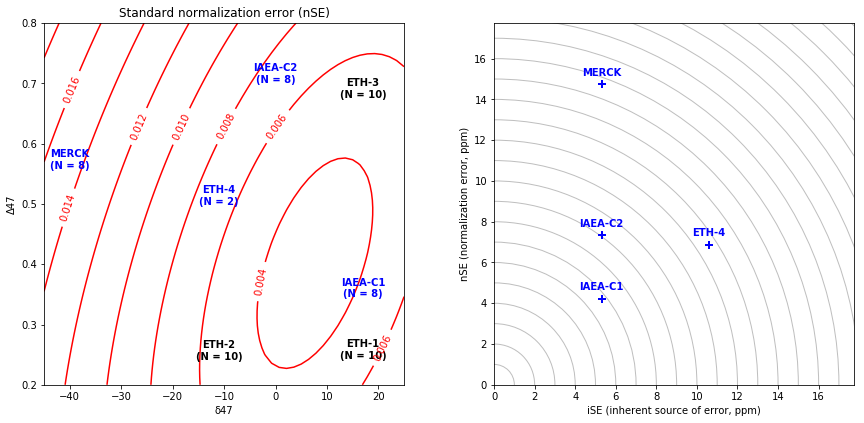

In [11]:
# define anchor measurements
anchors = []
anchors += [{'name':'ETH-1', 'd47':+17, 'D47':0.258, 'N':10}]
anchors += [{'name':'ETH-2', 'd47':-11, 'D47':0.256, 'N':10}]
anchors += [{'name':'ETH-3', 'd47':+17, 'D47':0.691, 'N':10}]

# define unknown measurements
unknowns = []
unknowns += [{'name':'ETH-4',   'd47':-11, 'D47':0.513, 'N':2}]
unknowns += [{'name':'IAEA-C1', 'd47':+17, 'D47':0.360, 'N':8}]
unknowns += [{'name':'IAEA-C2', 'd47':0,   'D47':0.716, 'N':8}]
unknowns += [{'name':'MERCK',   'd47':-40, 'D47':0.573, 'N':8}]

# define session-wide D47 reproducibility
rD47 = 0.015

compute_errors(rD47, anchors, unknowns)